# Transfer Learning - MNIST Data Set

## Overview

This notebook illustrates transfer learning using TensorFlow with the Keras API for specifing the CNN architecture. Program structure is based on [tf.contrib.keras API set](https://www.tensorflow.org/api_docs/python/tf/contrib/keras).  

Structure of the notebook:
* Obtain the MNIST data set
* Split the MNIST data set into even digit data set and odd digit data set
* Prepare image data for modeling, one-hot encode the digit label
* Load previously saved CNN model that was trained on even digit
* Freeze feature detection layers of the odd digit CNN model
* Train CNN model with frozen feature detection layer to recognize odd digits
* Evaluate model performance against odd and even test data sets

## Setup

In [1]:
import time
import os

import tensorflow as tf
from tensorflow.python.framework import ops

import numpy as np

## Obtain MNIST Data Set

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(".")

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [3]:
X_train, y_train = mnist.train.next_batch(mnist.train.num_examples)
X_test, y_test = mnist.test.next_batch(mnist.test.num_examples)

In [4]:
X_train = X_train.reshape(-1,28,28)
X_test = X_test.reshape(-1,28,28)

In [5]:
# load data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(55000, 28, 28)
(55000,)
(10000, 28, 28)
(10000,)


## Create even/odd data sets

In [6]:
# split into odd and evens
odds = [i for i,j in enumerate(y_train) if j % 2 == 1 ]
evens = list(set(range(len(y_train))) - set(odds))

X_train_odd = X_train[odds]
y_train_odd = y_train[odds]

X_train_even = X_train[evens]
y_train_even = y_train[evens]

# split into odd and evens
odds = [i for i,j in enumerate(y_test) if j % 2 == 1 ]
evens = list(set(range(len(y_test))) - set(odds))

X_test_odd = X_test[odds]
y_test_odd = y_test[odds]

X_test_even = X_test[evens]
y_test_even = y_test[evens]

## Prepare data for modeling

In [7]:
# TF specific Keras 
from tensorflow.contrib.keras.python.keras.utils import to_categorical

###
# function to prepare data for modeling
###
def prepareFeatureSet(X_in,y_in):
    # reshape to be [samples][channels][width][height]
    X_out = X_in.reshape(X_in.shape[0], 28, 28,1).astype('float32')

    # normalize inputs from 0-255 to 0-1
    #X_out = X_out / 255
    #X_out = X_in
    
    #one-hot encode target variable
    min_y = min(y_in)
    num_classes = len(np.unique(y_in))
    y_out = to_categorical((y_in-min_y)/2,num_classes)
    
    return((X_out,y_out))
    

In [8]:
###
# Prepare data for modeling
###
X_train_even_mdl, y_train_even_mdl = prepareFeatureSet(X_train_even,y_train_even)
X_test_even_mdl, y_test_even_mdl = prepareFeatureSet(X_test_even, y_test_even)

X_train_odd_mdl, y_train_odd_mdl = prepareFeatureSet(X_train_odd,y_train_odd)
X_test_odd_mdl, y_test_odd_mdl = prepareFeatureSet(X_test_odd, y_test_odd)

## Plot sample images

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def plotDigitGrid(X,y,idxs,y_hat=None):
    plt.figure(figsize=(12,10))

    for i in range(len(idxs)):
        plt.subplot(5,6,i+1)
        
        if y_hat is None:
            plt.title('Label: {label}'.format(label=y[idxs[i]]))
        else:
            plt.title("Label: {label}  Pred: {pred}".format(label=y[idxs[i]], pred=y_hat[idxs[i]]))
            
        plt.imshow(X[idxs[i]], cmap='Greys')
        plt.tick_params(
            axis='both',          # changes apply to the x-axis and y-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # tick marks on bottom side are off
            left='off',        # tick marks on left side are off
            labelleft='off',   # label on left side are off
            labelbottom='off') # labels along the bottom edge are off

    plt.show()


## Plot Sample Even Digits

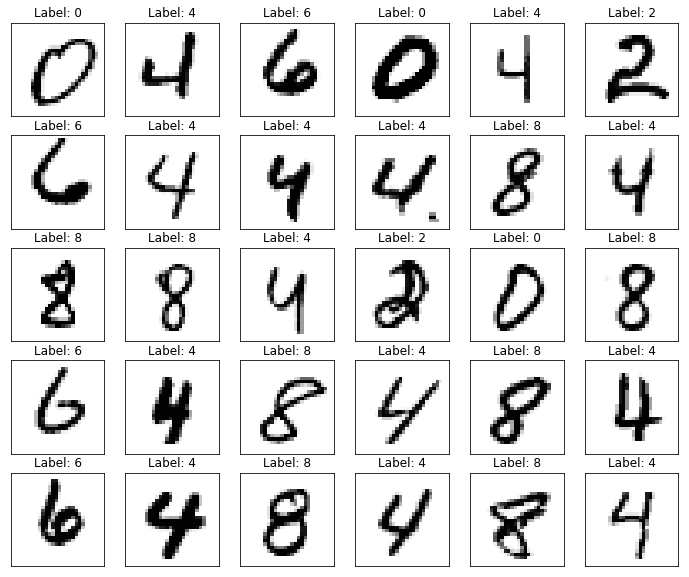

In [10]:
np.random.seed(127)
idxs_even = np.random.choice(y_test_even.shape[0],30)

plotDigitGrid(X_test_even,y_test_even,idxs_even)

## Plot Sample Odd Digits

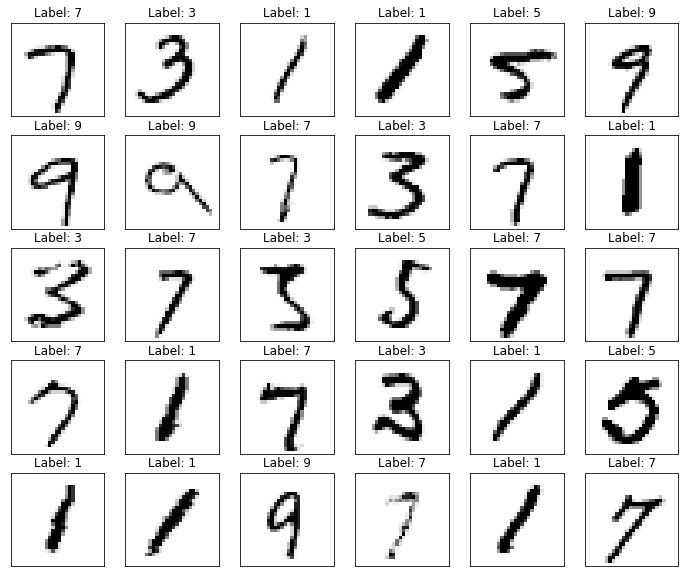

In [11]:
np.random.seed(127)
idxs_odd = np.random.choice(y_test_odd.shape[0],30)

plotDigitGrid(X_test_odd,y_test_odd,idxs_odd)

## Set up for model training

In [12]:
# reset computational TF compuationatl graph
ops.reset_default_graph()

# setup session for the even digit model
sess = tf.Session()
graph = sess.graph


## Global parameters for training

In [13]:
###
# function to train model
###
def train_model(model, x_train, y_train, x_test, y_test):
    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    t = time.time()
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1,
              validation_data=(x_test, y_test))
    print('Training time: %.3f (sec)' % (time.time() - t))
    
    return((time.time() - t))

In [14]:
BATCH_SIZE = 128

EPOCHS = 5

# ensure TF reproducibiliy
seed = 13
np.random.seed(seed)
tf.set_random_seed(seed)

## Transfer Learning
## Initialize Odd Digit Model from Even Digit Model

In [15]:
from tensorflow.contrib.keras.python.keras.models import load_model
###
# recerate model structure
###

# define cnn structure from the even_digit_model
odd_digit_model = load_model('./even_digit_model_tf_keras')

## Report Structure on Odd Digit Model Structure

In [16]:
for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
    print(v.name)

conv2d_1/kernel:0
conv2d_1/bias:0
conv2d_2/kernel:0
conv2d_2/bias:0
dense_1/kernel:0
dense_1/bias:0
dense_2/kernel:0
dense_2/bias:0
lr:0
decay:0
iterations:0
Variable:0
Variable_1:0
Variable_2:0
Variable_3:0
Variable_4:0
Variable_5:0
Variable_6:0
Variable_7:0
Variable_8:0
Variable_9:0
Variable_10:0
Variable_11:0
Variable_12:0
Variable_13:0
Variable_14:0
Variable_15:0


## Report Structure on Odd Digit Model Structure

In [17]:
for layer in odd_digit_model.layers:
    layer_name = layer.name
    layer_type = layer.__class__.__name__
    layer_trainable_flag = layer.trainable
    print (layer.name, layer_type, layer_trainable_flag)

conv2d_1 Conv2D True
conv2d_2 Conv2D True
max_pooling2d_1 MaxPooling2D True
dropout_1 Dropout True
flatten_1 Flatten True
dense_1 Dense True
dropout_2 Dropout True
dense_2 Dense True


## Freeze Feature Detection Layers

In [18]:
###
# Convoluation and MaxPooling Layers
###
for layer in odd_digit_model.layers:
    if layer.__class__.__name__ != 'Dense':
        layer.trainable = False

In [19]:
for layer in odd_digit_model.layers:
    layer_name = layer.name
    layer_type = layer.__class__.__name__
    layer_trainable_flag = layer.trainable
    print (layer.name, layer_type, layer_trainable_flag)

conv2d_1 Conv2D False
conv2d_2 Conv2D False
max_pooling2d_1 MaxPooling2D False
dropout_1 Dropout False
flatten_1 Flatten False
dense_1 Dense True
dropout_2 Dropout False
dense_2 Dense True


## Train Odd Digit Model

In [20]:
training_time = train_model(odd_digit_model,X_train_odd_mdl, y_train_odd_mdl, X_test_odd_mdl, y_test_odd_mdl)

Train on 27973 samples, validate on 5074 samples
Epoch 1/5
27973/27973 [==============================] - 6s - loss: 0.5826 - acc: 0.8413 - val_loss: 0.0814 - val_acc: 0.9758

In [21]:
odd_digit_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 30)        780       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 15)        11265     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 15)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 15)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               192128    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

## Odd Digit Model - Evaluate Model on Odd Digit Test Data Set

In [22]:
score = odd_digit_model.evaluate(X_test_odd_mdl, y_test_odd_mdl, verbose=0)
print('\nTest Loss:', score[0])
print('Test accuracy:', score[1])


Test Loss: 0.0345736753472
Test accuracy: 0.988175009854


5074/5074 [==============================] - 0s     


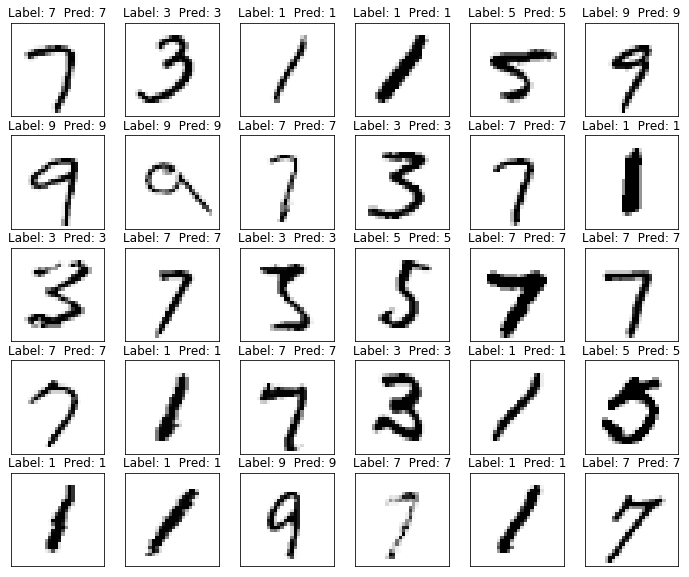

In [23]:
y_hat = odd_digit_model.predict_classes(X_test_odd_mdl)

plotDigitGrid(X_test_odd,y_test_odd,idxs_even,y_hat=2*y_hat+1)

## Odd Digit Model - Evaluate Even Digit Test Data Set

In [24]:
# report performance on even digit test data set
score = odd_digit_model.evaluate(X_test_even_mdl, y_test_even_mdl, verbose=0)
print('\nTest Loss:', score[0])
print('Test accuracy:', score[1])


Test Loss: 4.10758231647
Test accuracy: 0.273447016101


4704/4926 [===========================>..] - ETA: 0s

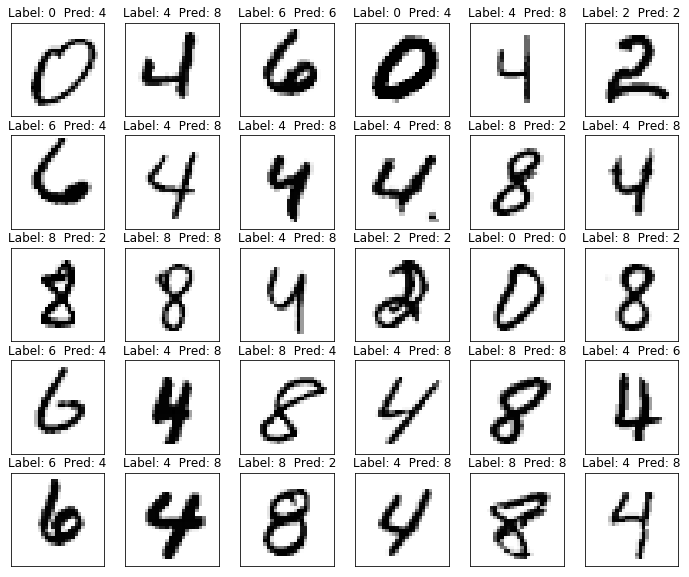

In [25]:
y_hat = odd_digit_model.predict_classes(X_test_even_mdl)

plotDigitGrid(X_test_even,y_test_even,idxs_even,y_hat=2*y_hat)